In [1]:
from utils import sars2_genome_info, get_parent
from utils_convergence import count_independent_occurrences, convergent_evo_dataframe, mean_rate_on_tree 
from utils_convergence import calc_mean_rate, rates_randomized_mut
from utils_randomization import get_branch_lengths, randomize_specific_mutations_multinomial
from utils_plotting import get_color_palette, convert_linege_names
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
from scipy import stats
from os import path
import os
import requests
import random
import json

## Figure 4: A 3-amino acid deletion in Nsp6 displays convergent evolution and occurs in successful clades

##### Mutations that appear many times over course of natural evolution of SARS-CoV-2 (convergently-evolved mutations) and are inherited by a descending clade (don't just die out) could be beneficial. They are likely neutral at worst. To find mutations associated with clade success, look for convergently-evolved mutations with high logistic growth rates after each independent occurrence

#### This notebook completes the analyses for Figures 4 A and B and Figure 4 Supplements 1 and 2. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15_20k.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Find all mutations that occurred on internal branches of the phylogeny (with at least 15 descending tips). Count how many times each of these mutations arose independently

In [3]:
all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(tree)

Plot a histogram of the number of independent times a mutation appears in the natural history of the virus. Just for interest, not to be included in the figure

In [4]:
def histogram_of_occurrences(filename=None):
    

    df = pd.DataFrame([{"mutation": mutation, "independent_occurrences": value} 
                       for mutation, value in independent_occurrences_all_mutations.items()])
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.histplot(x = 'independent_occurrences', data = df, ax=ax, discrete=True, 
                 color="#70c3b0", edgecolor="#ABABAB")
    
    print(len(df[df['independent_occurrences']>=4])/len(df))
    
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.set_ylabel('Count', size=12)
    ax.set_xlabel('Independent Occurrences', size=12)
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

0.04738154613466334


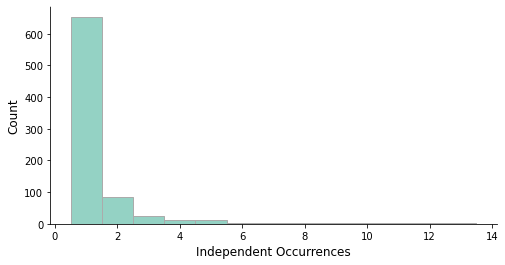

In [5]:
histogram_of_occurrences()

For every observed mutation, find the logistic growth rate of every clade that mutation occurs in. Make a dataframe with the number of times a mutation occurs, a list of these rates, and the average growth rate of clades with this mutation

In [6]:
df = convergent_evo_dataframe(tree, all_mutations_unique, independent_occurrences_all_mutations)

Plot number of occurrences versus average logisitic growth rate for each mutation. Zoom into the mutations that occur 4 or more times and label them

This function creates Figure 4A and Figure 4 Supplement 2.

In [27]:
def fig4a_occurrences_vs_growth(df, fig_to_plot, min_occurrences = 4, plot=True, filename=False):
    """
    Function to plot each mutation as a point in a scatterplot, with x-axis being the 
    number of times this mutation occurred across the phylogeny and the y-axis being 
    the average logistic growth rate of all clades where mutation occurs
    """
    
    # get rid of any entries that have NaN values for growth
    df = df.dropna()
    
    # take a subset of the data, only including mutations that appear `min_occurrences` of more times
    df_zoom = df.loc[df['independent_occurrences']>=min_occurrences].reset_index()
    
    # add a column saying whether or not the mutation occurs in S1
    df_zoom['mutation_location'] = df_zoom.apply(lambda row: 'S1' if row['mutation']== 'S:69/70del' 
                                                 else 'S1' if row['mutation'][0]=='S' 
                                                 and int(row['mutation'].split(':')[1][1:-1])<=685
                                                 and int(row['mutation'].split(':')[1][1:-1])>=13
                                                 else 'other', axis=1)

    
    # allow plotting to be toggled off to just return a list of top_scoring_muts
    # this is used to make Figure 4 Supplement 1
    if plot == False:

        top_scoring_muts = []
        for i in range(df_zoom.shape[0]):
            top_scoring_muts.append({'mutation':df_zoom.mutation[i], 
                                     'rate': df_zoom.avg_growth[i], 
                                     'num_occurrences': df_zoom.independent_occurrences[i], 
                                     'mutation_location': df_zoom.mutation_location[i]})
        
        top_scoring_muts_df = pd.DataFrame(top_scoring_muts)
        return top_scoring_muts_df
    
    
    # this makes Figure 4A and Supplement 2
    elif plot == True:
        
        # make dictionary with specifications specific to each different plot
        # this specifies title and adjustments to make labels more legible
        fig_specifications = {'4a':{'date_text': 'May 15, 2021', 'label':'A', 'adjustments': 
                                    {'S:501Y':{'x':0.09, 'y':0.4}, 
                                     'ORF1a:1640L':{'x':0.09, 'y':-0.2}, 
                                     'ORF3a:171L':{'x':0.09, 'y':0.05}, 
                                     'S:681R':{'x':0.09, 'y':-0.3}, 
                                     'S:452R':{'x':0.09, 'y':0.2},
                                     'ORF1a:3606F':{'x':-0.75, 'y':-0.6}, 
                                     'ORF1a:3675-3677del':{'x':-0.75, 'y':-0.6}}}, 
                              'supp_before':{'date_text': 'April 15, 2021', 'label':'A', 
                                             'adjustments': {'S:501Y':{'x':0.075, 'y':0.2}, 
                                                             'ORF9b:10S':{'x':0.075, 'y':-0.7},
                                                             'ORF1a:3675-3677del':{'x':-0.6, 'y':+0.45}}}, 
                              'supp_after':{'date_text': 'June 15, 2021', 'label':'C', 
                                            'adjustments': {'S:501Y':{'x':0.075, 'y':0.1}, 
                                                            'N:205I':{'x':0.075, 'y':0.2},
                                                            'N:199L':{'x':0.075, 'y':-0.4}}}}

        # two subplots: one showing all mutations, 
        # and one zoomed in to the mutations with highest values on both axes
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,6), gridspec_kw={'width_ratios': [1.5, 5]})
        sns.set_style('white')

        cmap1 = {'S1':"#4770eb",'other':"#ff5e31"}
        
        # plot all mutations on the first axis
        sns.scatterplot(x='independent_occurrences', y='avg_growth', 
                        data=df, ax=ax1, alpha=0.3,
                        color='#888888', legend = False)

        # find the "avg_growth" range of all mutations with at least `min_occurrences`
        max_growth = df[df['independent_occurrences']>=min_occurrences]['avg_growth'].max()
        min_growth = df[df['independent_occurrences']>=min_occurrences]['avg_growth'].min()


        # find max number of occurrences
        max_occurrences = df['independent_occurrences'].max()

        # plot mutations that occur 4 or more times on second axis
        sns.scatterplot(x='independent_occurrences', y='avg_growth', 
                        data=df_zoom, ax=ax2, s=100,
                        hue = 'mutation_location', hue_order=['S1', 'other'],
                        palette=cmap1, zorder=1)
        
        ax1.set_xlim(0, (max_occurrences + 1.0))
        ax1.set_xlabel('Independent occurrences of mutation', fontsize = 12)
        ax1.set_ylabel('Mean Logisitic Growth Rate', fontsize = 12)

        # truncate the plot space to only include relevant space around the mutations that occur 4 or more times
        ax2.set_ylim((min_growth - 1), (max_growth + 1))
        ax2.set_xlim((min_occurrences - 0.5), (max_occurrences + 0.75))
        ax2.set_xlabel('', fontsize = 12)
        ax2.set_ylabel('', fontsize = 12)
#         ax2.set_title(fig_specifications[fig_to_plot]['date_text'], fontsize=14)
        
        # add a box to the first plot showing the area included in the inset (second axis)
        ax1.add_patch(
            patches.Rectangle(
                xy=((min_occurrences - 0.5), (min_growth - 1)),  # point of origin.
                width=(max_occurrences - min_occurrences + 1),
                height= (max_growth - min_growth + 2),
                linewidth=1,
                color='#ffcec1',
                fill=False))
        
        # add horizontal line showing the mean growth rate of all clades on tree
        mean_growth_rate = mean_rate_on_tree(tree)
        ax2.axhline(mean_growth_rate, color='#ffcec1', lw=2, linestyle='--')

        # adjust appearance of axes
        ax1.spines['top'].set_color('white')
        ax1.spines['right'].set_color('white')
        
        ax2.spines['bottom'].set_color('#ffbeac')
        ax2.spines['top'].set_color('#ffbeac')
        ax2.spines['left'].set_color('#ffbeac')
        ax2.spines['right'].set_color('#ffbeac')
        
        plt.xticks(fontsize= 12)
        plt.yticks(fontsize= 12)

        # manually move some of the labels to make more legible
        for i in range(df_zoom.shape[0]):
            label_gene = df_zoom.mutation[i].split(':')[0]
            label_mut = df_zoom.mutation[i].split(':')[1][1:]

            label = f'{label_gene}:{label_mut}'
            if df_zoom.mutation[i] == 'ORF1a:3675-3677del':
                label = 'ORF1a:3675-3677del'
            elif df_zoom.mutation[i] == 'S:69/70del':
                label = 'S:69/70del'

            
            #manually specify adjustments to make labels legible
            adjustments = fig_specifications[fig_to_plot]['adjustments']
                
            if df_zoom.mutation[i] not in ['ORF1a:3676','ORF1a:3677']: 
                if label in adjustments.keys():
                    adjust_x = adjustments[label]['x']
                    adjust_y = adjustments[label]['y']
                else:
                    adjust_x = 0.09
                    adjust_y = -0.1
                ax2.text(x=df_zoom.independent_occurrences[i]+adjust_x,
                         y=df_zoom.avg_growth[i]+adjust_y,
                         s=label, 
                         ha='left',
                         fontdict=dict(color='black',size=10, rotation=0))

                
    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, title='Mutation Location')

    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    

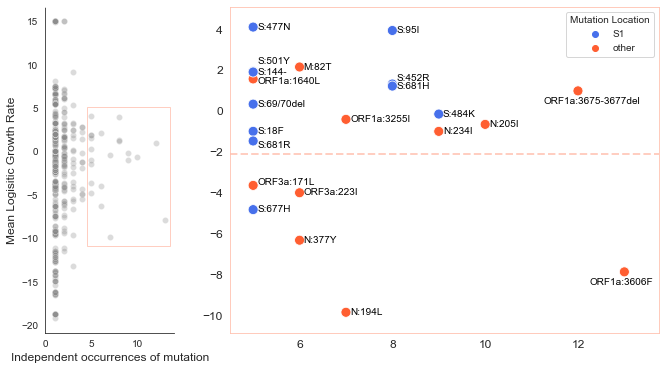

In [28]:
fig4a_occurrences_vs_growth(df, fig_to_plot='4a', min_occurrences=5, filename='plots/fig4asupp_convergentevo_20k.png')